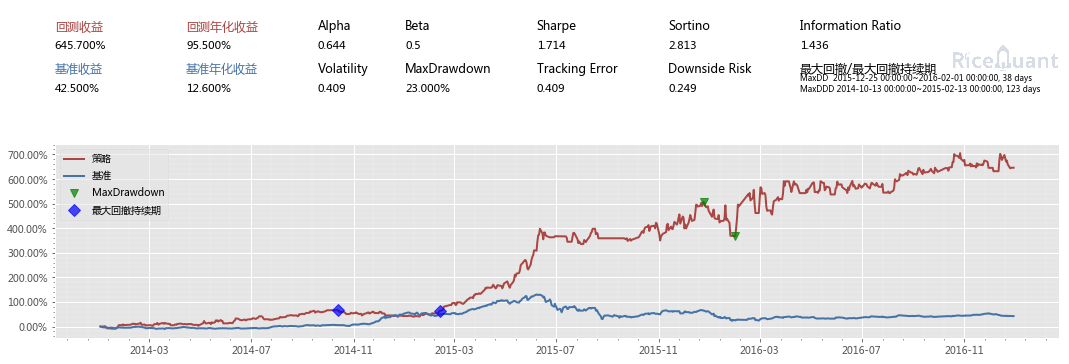

In [1]:
# -*- coding: utf-8 -*-
from rqalpha.api import *
from rqalpha import run_func
import pandas as pd
import talib as ta

def init(context):
    codes = pd.read_excel("F:/factor18.xlsx")
    codes.index = codes.pop('date')
    context.codes = codes
    scheduler.run_weekly(find_pool, tradingday=1)
    scheduler.run_weekly(buy, tradingday=1)
#    scheduler.run_daily(sell)    
    
    #设置持有时间，可以设置为五天，十天等。
    context.holdperiod = 10
    context.stocks = []
    context.time = []

def find_pool(context, bar_dict):
    try:
        codes = context.codes.loc[context.now]
    except KeyError:
        return
    stocks = codes.index[codes == True]
    context.stocks = stocks
    
def handle_bar(context, bar_dict):
    hold_period(context, bar_dict)
    sell(context, bar_dict)
    
def buy(context, bar_dict):
    pool = context.stocks
    if pool is not None:
        stocks_len = len(pool)
    cur_value = context.portfolio.market_value
    for stock in pool:
        data = history_bars(stock, 22, '1d', 'close')
#         print(type(data))
        up, mid, low = ta.BBANDS(data, timeperiod=21)
        signal = []
        if data[-1]>(mid[-1]):           
            signal.append(stock)
        position = len(signal)
        
        for right_stocks in signal:
            order_target_percent(stock, 1.0/position)       
            buy_time = context.now.replace(tzinfo=None)
            context.time = buy_time
            
def sell(context, bar_dict):
    for s in context.portfolio.positions:
        high = history_bars(s, 23, '1d', 'high')
        print high
        low = history_bars(s, 23, '1d', 'low')
        close = history_bars(s, 23, '1d', 'close')
        up, mid, low = ta.BBANDS(close, timeperiod=20)
        ATR = ta.ATR(high, low, close, timeperiod=10)
        print ATR
#         print mid
        
        if close[-1]<(mid[-1]):
            order_target_percent(s, 0)
            
def hold_period( context,bar_dict):
    for stock in context.portfolio.positions:
        buytime=context.time # 获取买入时间
        currenttime=context.now.replace(tzinfo=None) # 获取当前时间
#         print ('buytime='+str(buytime))
#         print('currenttime='+str(currenttime))
        hold_time=(currenttime-buytime).days # 计算持有天数
        if hold_time>context.holdperiod:
            order_target_percent(stock, 0)
            
config = {
  "base": {
    #设置回测开始时间
    "start_date": "2014-01-01",
    #设置回测结束时间
    "end_date": "2016-12-31",
    #设置回测的品种
    "accounts": {'stock':10000000},
    #设置基准收益
    "benchmark": "000300.XSHG"
  },
  "extra": {
    #查看最详细的日志，'error'只看错误。
    "log_level": "verbose",
  },
  "mod": {
    "sys_analyser": {
        #保存report至当下文件
        "report_save_path": '.',
        #启动策略逐行性能分析
        "enabled": True,
        #打印图形
        "plot": True
     },
    "sys_simulation": {
        #是否限制买入涨停板
        "price_limit":False,
        "enabled": True,
        #设置手续费的倍数，默认是10
        "commission_multiplier": 0,
        #设置滑点
        "slippage": 0
    }
  }
}

results = run_func(init=init, handle_bar=handle_bar, config=config)
#results = run_func(init=init, config=config)